In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

## arimax

In [2]:
# import pandas as pd

# train = pd.read_csv('/content/merged_train (1).csv')
# test = pd.read_csv('/content/merged_test (1).csv')

# train.columns = [c.lower().strip() for c in train.columns]
# test.columns = [c.lower().strip() for c in test.columns]

# data = pd.concat([train, test], axis=0).reset_index(drop=True)
# data['date'] = pd.to_datetime(data['date'])

# target_col = 'close'
# date_col = 'date'
# exog_cols = [col for col in data.columns if col not in [date_col, target_col]]


In [3]:
# from statsmodels.tsa.statespace.sarimax import SARIMAX

# y = data[target_col]
# X = data[exog_cols]

# from statsmodels.tsa.stattools import adfuller
# print("ADF p-value:", adfuller(y)[1])

# model = SARIMAX(y, exog=X, order=(1,1,1))
# fit = model.fit(disp=False)

# print(fit.summary())


## LSTM

In [4]:
import random
import numpy as np
import torch

# 시드 고정 (여기에 추가)
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
train = pd.read_csv('/content/merged_train (1).csv')
test = pd.read_csv('/content/merged_test (1).csv')
train.columns = [c.lower().strip() for c in train.columns]
test.columns = [c.lower().strip() for c in test.columns]
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])
data = pd.concat([train, test], axis=0).reset_index(drop=True)

target_col = 'close'
date_col = 'date'
feature_cols = ['neu','trend']

In [6]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data[feature_cols])

def create_sequences(data, seq_length, target_idx):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length, target_idx]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [7]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, output_size=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

def inverse_transform(preds_scaled, scaler, feature_cols, target_col):
    temp = np.zeros((len(preds_scaled), len(feature_cols)))
    # 예측값을 close 위치(=0)로 설정 (입력이 neu만이므로 feature_cols[0]은 neu)
    # 타깃(close) 역변환 시 scaler를 새로 fit 해야 함 (close의 min/max 필요)
    # train+test에서 close만 따로 scaler를 fit
    close_scaler = MinMaxScaler()
    close_scaler.fit(data[[target_col]])
    return close_scaler.inverse_transform(np.array(preds_scaled).reshape(-1, 1)).flatten()



====== window size: 5 ======
Epoch 1, Loss: 0.2173
Epoch 20, Loss: 0.0659
Epoch 40, Loss: 0.0520
Epoch 60, Loss: 0.0492
Epoch 80, Loss: 0.0451
Epoch 100, Loss: 0.0420
Test MAE: 2.3100, RMSE: 2.7137


<ipython-input-8-c5d15b568a2e>:72: UserWarning: Glyph 47564 (\N{HANGUL SYLLABLE MAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47564 (\N{HANGUL SYLLABLE MAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


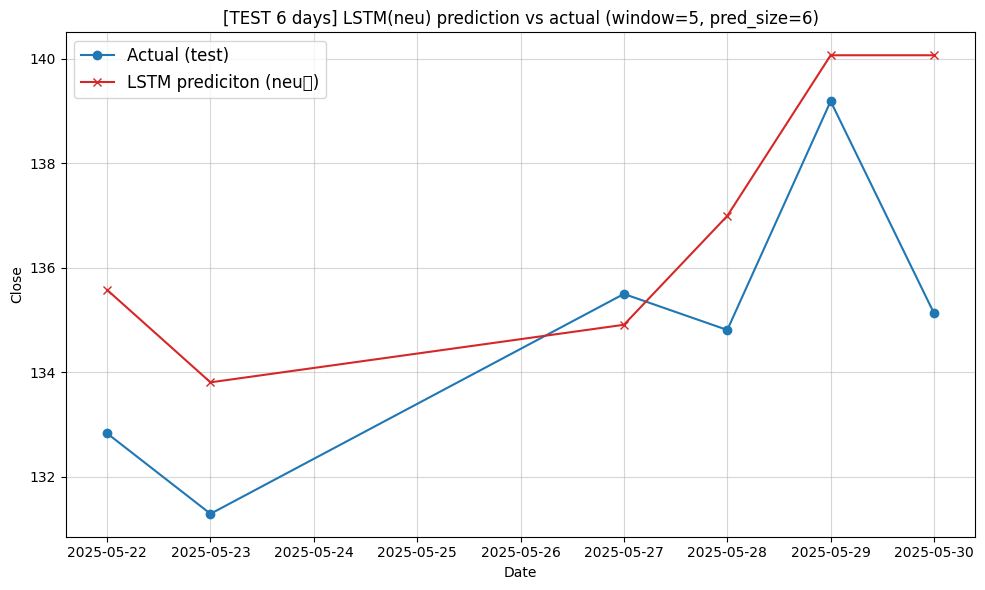


[LSTM(neu) TEST 6 days comparison]
   window_size       mae      rmse
0            5  2.310041  2.713741


In [8]:
window_sizes = [5]
pred_size = 6
result_list = []

for seq_length in window_sizes:
    print(f"\n====== window size: {seq_length} ======")
    input_size = len(feature_cols)
    target_idx = 0  # neu만 있으니 0번째 컬럼
    num_epochs = 100
    learning_rate = 0.001

    # 전체 구간 시퀀스 생성 (타깃: close)
    # 타깃값은 따로 추출해서 MinMax scaling 필요
    close_scaler = MinMaxScaler()
    close_scaled = close_scaler.fit_transform(data[[target_col]]).flatten()

    X, y = create_sequences(scaled, seq_length, target_idx=None)
    # y를 close_scaled에서 슬라이싱해서 생성
    y = close_scaled[seq_length:]

    X_torch = torch.tensor(X, dtype=torch.float32)
    y_torch = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LSTM(input_size).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # 학습
    for epoch in range(1, num_epochs+1):
        model.train()
        optimizer.zero_grad()
        output = model(X_torch.to(device))
        loss = criterion(output, y_torch.to(device))
        loss.backward()
        optimizer.step()
        if epoch % 20 == 0 or epoch == 1:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    # 마지막 window에서 test 6일 rolling 예측
    window = scaled[-(pred_size+seq_length):-pred_size].copy()
    preds_scaled = []
    for i in range(pred_size):
        input_x = torch.tensor(window[np.newaxis], dtype=torch.float32).to(device)
        with torch.no_grad():
            pred = model(input_x).cpu().numpy().flatten()[0]
        preds_scaled.append(pred)
        # window rolling
        next_row = window[-1].copy()
        next_row[0] = window[-1][0]  # neu의 미래값은 관측값 없으므로 마지막값 유지
        window = np.vstack([window[1:], next_row])

    # 역변환 (close scaler 사용)
    preds_inv = close_scaler.inverse_transform(np.array(preds_scaled).reshape(-1, 1)).flatten()
    y_true = test[target_col].values[:pred_size]
    test_dates = test['date'].values[:pred_size]

    from sklearn.metrics import mean_absolute_error, mean_squared_error
    mae = mean_absolute_error(y_true, preds_inv)
    rmse = np.sqrt(mean_squared_error(y_true, preds_inv))
    print(f"Test MAE: {mae:.4f}, RMSE: {rmse:.4f}")

    # 예측구간만 크게 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(test_dates, y_true, marker='o', label='Actual (test)', color='tab:blue')
    plt.plot(test_dates, preds_inv, marker='x', label='LSTM prediciton (neu만)', color='tab:red')
    plt.title(f'[TEST 6 days] LSTM(neu) prediction vs actual (window={seq_length}, pred_size={pred_size})')
    plt.xlabel('Date')
    plt.ylabel('Close')
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.5)
    plt.tight_layout()
    plt.show()

    result_list.append({'window_size': seq_length, 'mae': mae, 'rmse': rmse})

result_df = pd.DataFrame(result_list)
print("\n[LSTM(neu) TEST 6 days comparison]")
print(result_df)


# 랜포 (버리기)


Test Accuracy: 0.5000
              precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       0.40      1.00      0.57         2

    accuracy                           0.50         6
   macro avg       0.70      0.62      0.49         6
weighted avg       0.80      0.50      0.46         6



<ipython-input-9-05df3ec35b9e>:57: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-9-05df3ec35b9e>:57: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-9-05df3ec35b9e>:57: UserWarning: Glyph 46321 (\N{HANGUL SYLLABLE DEUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-9-05df3ec35b9e>:57: UserWarning: Glyph 46973 (\N{HANGUL SYLLABLE RAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-9-05df3ec35b9e>:57: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-9-05df3ec35b9e>:57: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-9-05df3ec35b9e>:57: UserWarning: Glyph 54616 (\N{HANGUL SYLLABLE HA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-inpu

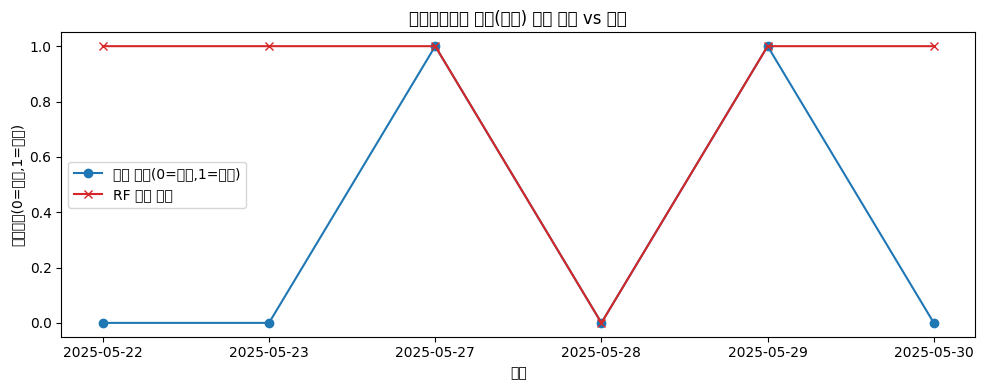

In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler

# 데이터 불러오기
train = pd.read_csv('/content/merged_train (1).csv')
test = pd.read_csv('/content/merged_test (1).csv')
train.columns = [c.lower().strip() for c in train.columns]
test.columns = [c.lower().strip() for c in test.columns]

target_col = 'close'
date_col = 'date'

# 등락여부(상승=1, 하락/보합=0) 생성
train['updown'] = (train[target_col].diff() > 0).astype(int).fillna(0)
test['updown'] = (test[target_col].diff() > 0).astype(int).fillna(0)

# feature_cols: 종가/날짜/등락여부 제외
feature_cols = [col for col in train.columns if col not in [date_col, target_col, 'updown']]

# 결측치 채우기
train = train.fillna(0)
test = test.fillna(0)

# 스케일링 (RandomForest에는 필수 아님, 선택)
scaler = MinMaxScaler()
train_X = scaler.fit_transform(train[feature_cols])
test_X = scaler.transform(test[feature_cols])

train_y = train['updown'].values
test_y = test['updown'].values

# 랜덤포레스트 분류기
clf = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42)
clf.fit(train_X, train_y)

# 예측
pred = clf.predict(test_X)
prob = clf.predict_proba(test_X)[:, 1]

# 평가
acc = accuracy_score(test_y, pred)
print(f"Test Accuracy: {acc:.4f}")
print(classification_report(test_y, pred))

# 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(test[date_col], test_y, label='실제 등락(0=하락,1=상승)', marker='o')
plt.plot(test[date_col], pred, label='RF 예측 등락', marker='x', color='tab:red')
plt.title('랜덤포레스트 등락(이진) 분류 예측 vs 실제')
plt.xlabel('날짜')
plt.ylabel('등락여부(0=하락,1=상승)')
plt.legend()
plt.tight_layout()
plt.show()
